In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hwk3-task1-spills.ipynb")

# Complete WorkFlow

The year of this data frame: [2023]
The months of this data frame: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


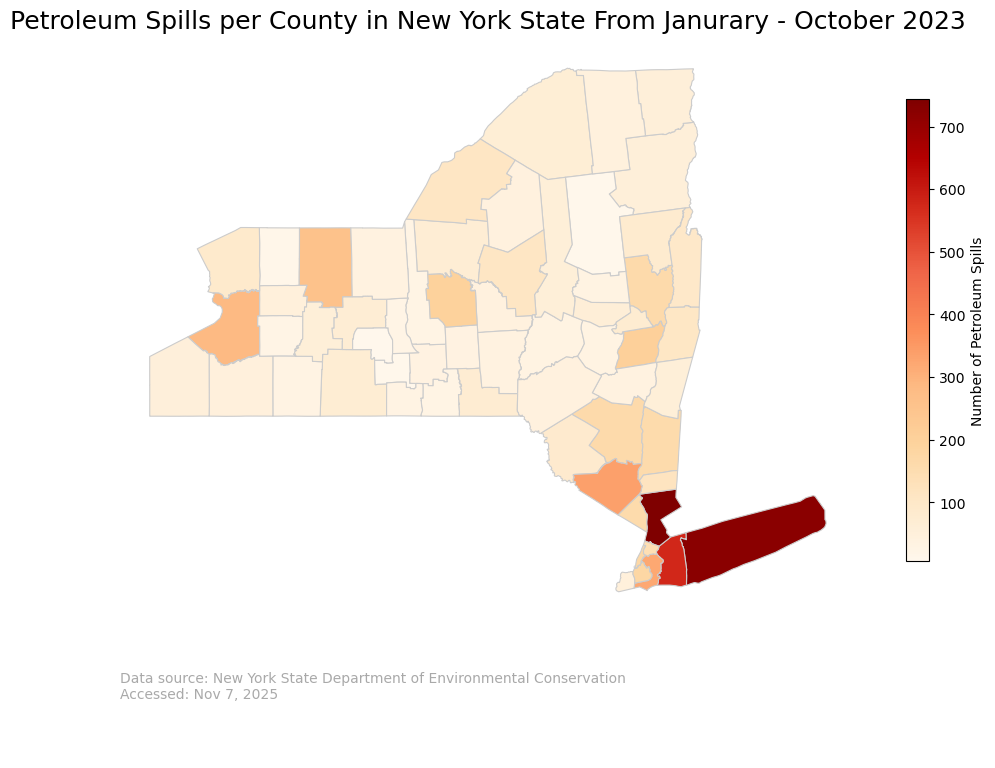

In [2]:
# Importing Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# To remove an error message to produce map
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

# Importing CSV from Oil Spills
fp = os.path.join('data','Spill_Incidents_20251103.csv')
spills = pd.read_csv(fp)

# Importing Shapefile from US Census Bureau
fp = os.path.join('data','tl_2023_us_county.shp')
counties = gpd.read_file(fp)

# Make headers all lowercase, remove spaces and replace with underscore
spills.columns = spills.columns.str.lower().str.replace(' ', '_')

#Convert date columns to datetime
date_cols = ['spill_date', 'received_date', 'close_date']
for col in date_cols:
    spills[col] = pd.to_datetime(spills[col], errors='coerce')
    
# Select petroleum spills between Jan 1, 2023 and Oct 31, 2023
petr_23 = spills[
    
    (spills['material_family'] == 'Petroleum') &
    (spills['spill_date'] >= '2023-01-01') &
    (spills['spill_date'] <= '2023-10-31')
]

# Create new dataframe of Country and Number of Spills
spills_per_county = (
    #Grouping by 'Country' and counting 'spill_number'
    petr_23.groupby('county')['spill_number']
    .count()
)

# Resetting index
spills_per_county =  spills_per_county.reset_index(name='n_spills')



# View datetime for print statement
petr_23.spill_date.dt.year.unique()
#petr_23['spill_date'].unique


# Check all entries are from the date range
print(f"The year of this data frame: {petr_23.spill_date.dt.year.unique()}")
print(f"The months of this data frame: {sorted(petr_23.spill_date.dt.month.unique())}")

# Clean column names for counties shapefile
counties.columns = (
    counties.columns
    # Remove spaces
    .str.strip()
    # Lowercase all names
    .str.lower()  
    # Replace spaces with underscores
    .str.replace(' ', '_'))       

# Select the states of New York, using statefp
ny_counties = counties[counties['statefp'] == '36']

# Verify 'St Lawrence' on spills per county 
spills_per_county[spills_per_county['county'] == 'St Lawrence']
# Replace value
spills_per_county['county'] = spills_per_county['county'].replace({'St Lawrence':'St. Lawrence'})

# Lowercase values in county column
spills_per_county['county'] = spills_per_county['county'].str.lower()
ny_counties['name'] = ny_counties['name'].str.lower()
# Renaming column on ny_counties to match spills per county
ny_counties = ny_counties.rename(columns={'name': 'county'})

# Perform the inner join and overwrite ny_counties
ny_counties = ny_counties.merge(
    spills_per_county[['county', 'n_spills']],
    on='county',
    how='inner')

# Increment Niagara
ny_counties.loc[ny_counties['county'] == 'Niagara', 'n_spills'] += 1

# MAP
# Set up figure
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the choropleth
ny_counties.plot(
    # Column to color by
    column='n_spills', 
    # Color map (Orange-Red)
    cmap='OrRd',  
    # County boundaries width
    linewidth=0.8, 
    # County boundaries color (gray)
    edgecolor='0.8', 
    # Show legend
    legend=True,               
    legend_kwds={'label': "Number of Petroleum Spills",  # Title
                 # Size of scale bar
                 'shrink': 0.6,
                 # Location of scale
                 'orientation': 'vertical'},
    # Assinging it back to the fig, ax
    ax=ax)

# Axes
ax.axis('off')

# Title
ax.set_title("Petroleum Spills per County in New York State From Janurary - October 2023", fontdict={'fontsize': 18}, pad=10)

# Add annotation with source and access date
plt.annotate(
    "Data source: New York State Department of Environmental Conservation \nAccessed: Nov 7, 2025",
    # xy = location of annotation text
    xy=(0.1, 0.07), 
    xycoords='figure fraction',
    fontsize=10, color='darkgrey')

# Show plot
plt.show()

# Task 1: Visualizing oil spills in NY State

## Instructions

- First, update the following cell to have a link to *your* Homework 2 GitHub repository:

**UPDATE THIS LINK**
https://github.com/marietolteca00/eds220-hwk3.git

- Review the [complete rubric for this task](https://docs.google.com/document/d/1x0BoU6IH4cnOR1-n7i9CYQ9wUC37yDpYlQ4j6rCfcsU/edit?tab=t.0) before starting.

- **Meaningful commits should be made every time you finish a major step.** We'll check your repository and view the commit history.

- Comment mindfully in a way that enriches your code. Comments should follow best practices.

- **Do not update the top cell with the `otter` import**, this is used internally for grading.


## About the data
In this task you will use two datsets:

### First dataset: oil spills data

The first dataset contains information about [spilling incidents in the state of New York](https://data.ny.gov/Energy-Environment/Spill-Incidents/u44d-k5fk). 
The data portal has plenty of information. 
You will find extra information and metadata for this datset in the `NYSDEC_SpillIncidents_Overview.pdf` and `NYSDEC_SpillIncidents_DataDictionary.pdf` documents available at the portal.

### Second dataset: TIGER shapefile

The second dataset is the [the 2023 Counties (and equivalent) TIGER shapefile](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341) from the Census Bureau. You can check the [metadata for all the TIGER shapefiles here](https://www.census.gov/programs-surveys/geography/technical-documentation/complete-technical-documentation/tiger-geo-line.html). 

## 1. File management
a. Create a `data/` directory inside your `eds220-hwk3` directory. If you download any data, it should be transferred into this folder. 

b. Add the `data/` directory to your `.gitignore` file and push your changes. This is IMPORTANT: the datasets we'll be working with are large and they will most likely jam your commit history if you try to push them.

## 2. Datasets description
- Read the metadata for both datsets and write a brief description about each one. Indicate the date sources and date of access.

Oil spill data: New York State Department of Environmental Conservation.[https://data.ny.gov/Energy-Environment/Spill-Incidents/u44d-k5fk/about_data]. Date of Access: November 03, 2025. This dataset contains information on spills of pretroleum and other hazardous material that have been reported in the New York State Department of Environmental Conservation under state law and regulations. 

TIGER shapefile: United States Census Bureau. https://www.census.gov/programs-surveys/geography/technical-documentation/complete-technical-documentation/tiger-geo-line.html. Date of Access: November 03, 2025. This dataset contains shapefiles that will be used to create a map of the state of New York, with the county boundary file. This dataset also includes Combined Statistical Areas (CSAs) and Core Based Statistical Areas (CBSAs).

## 3. Import libraries

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

## 4. Import data 
In the next cell:

- Import the NY spills data as a variable named `spills`. 
- Import the US counties data as a variable named `counties`.

If you are using file paths to access the data, these should be constructed using the `os` package.

In [4]:
# Importing CSV from Oil Spills
fp = os.path.join('data','Spill_Incidents_20251103.csv')
spills = pd.read_csv(fp)

# Importing Shapefile from US Census Bureau
fp = os.path.join('data','tl_2023_us_county.shp')
counties = gpd.read_file(fp)


<!-- BEGIN QUESTION -->

## 5. Prepare spills data

This section refers to the `spills` dataframe. 
Check the outputs carefully, they will give you information you will need to use in the next exercises.

### 5.A. Exploration

In the next cells:

a. Check the dataframe's head

b. Check the data types of the columns

c. Check the unique values in the `material_family` column

d. Check the unique values in the `county` column

e. Insert a markdown cell to explain what information you obtained from the preliminary exploration. Use complete sentences.

You can add any other cells for preliminary data exploration.

In [5]:
#a. Check the dataframe's head
spills.head()

,Spill Number,Program Facility Name,Street 1,Street 2,Locality,County,ZIP Code,SWIS Code,DEC Region,Spill Date,Received Date,Contributing Factor,Waterbody,Source,Close Date,Material Name,Material Family,Quantity,Units,Recovered
0,107132,MH 864,RT 119/MILLWOOD RD,NaN,ELMSFORD,Westchester,NaN,6000,3,10/10/2001,10/10/2001,Unknown,NaN,Unknown,10/15/2001,unknown material,Other,10,Gallons,0
1,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,08/21/2004,08/21/2004,Other,EAST RIVER,Unknown,09/17/2004,raw sewage,Other,0,NaN,0
2,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,08/21/2004,08/21/2004,Other,EAST RIVER,Unknown,09/17/2004,raw sewage,Other,0,Pounds,0
3,204667,POLE 16091,GRACE AVE/BURKE AVE,NaN,BRONX,Bronx,NaN,301,2,08/02/2002,08/02/2002,Equipment Failure,NaN,Commercial/Industrial,10/28/2002,transformer oil,Petroleum,1,Gallons,0
4,210559,POLE ON,FERDALE LOMIS RD / RT 52,NaN,LIBERTY,Sullivan,NaN,5336,3,01/20/2003,01/20/2003,Traffic Accident,NaN,Commercial/Industrial,01/22/2003,transformer oil,Petroleum,6,Gallons,6


In [6]:
#b. Check the data types of the columns
print(spills.dtypes)

Spill Number              int64
Program Facility Name    object
Street 1                 object
Street 2                 object
Locality                 object
County                   object
ZIP Code                 object
SWIS Code                 int64
DEC Region                int64
Spill Date               object
Received Date            object
Contributing Factor      object
Waterbody                object
Source                   object
Close Date               object
Material Name            object
Material Family          object
Quantity                 object
Units                    object
Recovered                object
dtype: object


In [7]:
#c. Check the unique values in the `material_family` column
spills['Material Family'].unique()
spills['Program Facility Name'].unique()

array(['MH 864', 'BOWRY BAY', 'POLE 16091', ..., '`-NYCT / 146 ST',
       '`-NYCT BUS DEPOT - S I', '`-RAVENSWOOD'], dtype=object)

In [8]:
#d. Check the unique values in the `county` column
spills['County'].unique()
spills.nunique()
spills.isna().sum()

Spill Number                  0
Program Facility Name         6
Street 1                    134
Street 2                 519736
Locality                   1137
County                        0
ZIP Code                 508365
SWIS Code                     0
DEC Region                    0
Spill Date                  151
Received Date               476
Contributing Factor           0
Waterbody                516076
Source                        0
Close Date                11625
Material Name                 0
Material Family               0
Quantity                      0
Units                    115553
Recovered                     0
dtype: int64

e.
From the spills dataframe, I observed that it includes various details about each incident, such as the location of the spill, the units involved, and the type of material (both by family and specific name). The data exploration also revealed that most columns are stored as object types, and notably, the date values are not yet in a proper datetime format, which may require conversion for time-based analysis.
For the counties TIGER shapefile, most of the attributes are stored as object types, except for the land and water area fields, which are stored as integers. This indicates that while most information is categorical or descriptive, a few columns contain numerical data suitable for quantitative analysis.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 5.B. Cleaning
a. Simplify column names as needed.

In [9]:
# Make headers all lowercase, remove spaces and replace with underscore
spills.columns = spills.columns.str.lower().str.replace(' ', '_')

In [10]:
#Convert date columns to datetime
date_cols = ['spill_date', 'received_date', 'close_date']
for col in date_cols:
    spills[col] = pd.to_datetime(spills[col], errors='coerce')
    
# Confirming Data Types Changed
spills.head()

,spill_number,program_facility_name,street_1,street_2,locality,county,zip_code,swis_code,dec_region,spill_date,received_date,contributing_factor,waterbody,source,close_date,material_name,material_family,quantity,units,recovered
0,107132,MH 864,RT 119/MILLWOOD RD,NaN,ELMSFORD,Westchester,NaN,6000,3,2001-10-10,2001-10-10,Unknown,NaN,Unknown,2001-10-15,unknown material,Other,10,Gallons,0
1,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,2004-08-21,2004-08-21,Other,EAST RIVER,Unknown,2004-09-17,raw sewage,Other,0,NaN,0
2,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,2004-08-21,2004-08-21,Other,EAST RIVER,Unknown,2004-09-17,raw sewage,Other,0,Pounds,0
3,204667,POLE 16091,GRACE AVE/BURKE AVE,NaN,BRONX,Bronx,NaN,301,2,2002-08-02,2002-08-02,Equipment Failure,NaN,Commercial/Industrial,2002-10-28,transformer oil,Petroleum,1,Gallons,0
4,210559,POLE ON,FERDALE LOMIS RD / RT 52,NaN,LIBERTY,Sullivan,NaN,5336,3,2003-01-20,2003-01-20,Traffic Accident,NaN,Commercial/Industrial,2003-01-22,transformer oil,Petroleum,6,Gallons,6


In [11]:
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477563029,10772508,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980771,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."
2,35,011,00933054,35011,0500000US35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."
3,31,109,00835876,31109,0500000US31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169269688,22850324,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523..."
4,31,129,00835886,31129,0500000US31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645187,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27370 40.11840, -98.27374 40.122..."


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

b. Update column data types as needed *for this analysis*.

In [12]:
#print(spills.dtypes)
#counties.dtypes
spills.head()

,spill_number,program_facility_name,street_1,street_2,locality,county,zip_code,swis_code,dec_region,spill_date,received_date,contributing_factor,waterbody,source,close_date,material_name,material_family,quantity,units,recovered
0,107132,MH 864,RT 119/MILLWOOD RD,NaN,ELMSFORD,Westchester,NaN,6000,3,2001-10-10,2001-10-10,Unknown,NaN,Unknown,2001-10-15,unknown material,Other,10,Gallons,0
1,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,2004-08-21,2004-08-21,Other,EAST RIVER,Unknown,2004-09-17,raw sewage,Other,0,NaN,0
2,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,2004-08-21,2004-08-21,Other,EAST RIVER,Unknown,2004-09-17,raw sewage,Other,0,Pounds,0
3,204667,POLE 16091,GRACE AVE/BURKE AVE,NaN,BRONX,Bronx,NaN,301,2,2002-08-02,2002-08-02,Equipment Failure,NaN,Commercial/Industrial,2002-10-28,transformer oil,Petroleum,1,Gallons,0
4,210559,POLE ON,FERDALE LOMIS RD / RT 52,NaN,LIBERTY,Sullivan,NaN,5336,3,2003-01-20,2003-01-20,Traffic Accident,NaN,Commercial/Industrial,2003-01-22,transformer oil,Petroleum,6,Gallons,6


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 5.C. Data selection

a. Select data about petroleum spills that took place between January 1st 2023, and October 31st (including both dates), 2023. Store it in a variable named `petr_23`. The data selection should occur in a single line. You may add cells as needed.

In [13]:
# Checking values on this 'program_facility_name'
spills['program_facility_name'].unique()

array(['MH 864', 'BOWRY BAY', 'POLE 16091', ..., '`-NYCT / 146 ST',
       '`-NYCT BUS DEPOT - S I', '`-RAVENSWOOD'], dtype=object)

In [14]:
# Select petroleum spills between Jan 1, 2023 and Oct 31, 2023
petr_23 = spills[
    
    (spills['material_family'] == 'Petroleum') &
    (spills['spill_date'] >= '2023-01-01') &
    (spills['spill_date'] <= '2023-10-31')
]

# Viewing spill date
print(petr_23.head())
# Viewing total columns and rows
print(petr_23.shape)

# Make sure Tuscarora is in for a problem ahead!
print(petr_23[petr_23['county'].str.contains('Tuscarora', case=False, na=False)])


     spill_number program_facility_name            street_1 street_2  \
221       2301892    *** TEST SPILL ***  *** TEST SPILL ***      NaN   
222       2301892    *** TEST SPILL ***  *** TEST SPILL ***      NaN   
223       2301892    *** TEST SPILL ***  *** TEST SPILL ***      NaN   
224       2301892    *** TEST SPILL ***  *** TEST SPILL ***      NaN   
225       2301892    *** TEST SPILL ***  *** TEST SPILL ***      NaN   

               locality    county zip_code  swis_code  dec_region spill_date  \
221  *** TEST SPILL ***  Onondaga    00000       3415           7 2023-06-06   
222  *** TEST SPILL ***  Onondaga    00000       3415           7 2023-06-06   
223  *** TEST SPILL ***  Onondaga    00000       3415           7 2023-06-06   
224  *** TEST SPILL ***  Onondaga    00000       3415           7 2023-06-06   
225  *** TEST SPILL ***  Onondaga    00000       3415           7 2023-06-06   

    received_date contributing_factor waterbody   source close_date  \
221    2023-06-

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

b. Use `print()` and f-strings to print a message verifying that `petr_23` only has data for 2023 and from January through October.
HINT: if you converted the `spill_date` column to datetime, you can use `petr_23.spill_date.dt.year.unique()`.

In [15]:
# View datetime for print statement
petr_23.spill_date.dt.year.unique()
#petr_23['spill_date'].unique

# Check all entries are from the date range
print(f"The year of this data frame: {petr_23.spill_date.dt.year.unique()}")
print(f"The months of this data frame: {sorted(petr_23.spill_date.dt.month.unique())}")


The year of this data frame: [2023]
The months of this data frame: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

c. Write tests using `assert` to verify that `petr_23` only has data for petroleum spills.

In [16]:
# Assert all rows in 'material_family' are 'Petroleum'
# Function: assert (CONDITION).all(), "ERROR MESSAGE IF FALSE"
assert (petr_23['material_family'] == 'Petroleum').all(), "Non-petroleum spills found in petr_23" #need to inclue .all() if not error message


<!-- END QUESTION -->

### 5.D. Data aggregation

Create new dataframe named `spills_per_county` with the number of petroleum spills per county from January to October 2023 (i.e. use the `petr_23` dataframe).

The resulting `spills_per_county` dataframe must be as follows:

- Index: integer numbers starting from 0
- Two columns only.
- Column one: county names, column name = `county`
- Column two: number of petroleum spills per county in 2023, column name = `n_spills`

You may add cells if needed.

In [17]:
# Viewing dataframe
petr_23.head(2)
petr_23.dtypes

spill_number                      int64
program_facility_name            object
street_1                         object
street_2                         object
locality                         object
county                           object
zip_code                         object
swis_code                         int64
dec_region                        int64
spill_date               datetime64[ns]
received_date            datetime64[ns]
contributing_factor              object
waterbody                        object
source                           object
close_date               datetime64[ns]
material_name                    object
material_family                  object
quantity                         object
units                            object
recovered                        object
dtype: object

In [18]:
# Create new dataframe of Country and Number of Spills
spills_per_county = (
    #Grouping by 'Country' and counting 'spill_number'
    petr_23.groupby('county')['spill_number']
    .count()
)

# Resetting index
spills_per_county =  spills_per_county.reset_index(name='n_spills')

# Printing dataframe
spills_per_county.head()

# Make sure it exist for problem ahead
spills_per_county[spills_per_county['county'].str.contains('Tuscarora', case=False, na=False)]


,county,n_spills
56,Tuscarora Indian Reservation,1


In [19]:
grader.check("q5d")

q5d results:
    q5d - 1 result:
        ❌ Test case failed
        Trying:
            def test_q3(student_data):
                try:
                    expected_data = pd.read_csv('data/q5d_df.csv').drop(columns='Unnamed: 0')
                    pd.testing.assert_frame_equal(expected_data, student_data)
                except AssertionError:
                    raise AssertionError('Incorrect answer.')
        Expecting nothing
        ok
        Trying:
            test_q3(spills_per_county)
        Expecting nothing
        **********************************************************************
        Line 7, in q5d 0
        Failed example:
            test_q3(spills_per_county)
        Exception raised:
            Traceback (most recent call last):
              File "<doctest q5d 0[0]>", line 4, in test_q3
                pd.testing.assert_frame_equal(expected_data, student_data)
              File "/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/pandas/_testing/asserters.py", line 1279, in assert_frame_equal
                assert_series_equal(
              File "/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/pandas/_testing/asserters.py", line 997, in assert_series_equal
                assert_numpy_array_equal(
              File "/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/pandas/_testing/asserters.py", line 690, in assert_numpy_array_equal
                _raise(left, right, err_msg)
              File "/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/pandas/_testing/asserters.py", line 684, in _raise
                raise_assert_detail(obj, msg, left, right, index_values=index_values)
              File "/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/pandas/_testing/asserters.py", line 614, in raise_assert_detail
                raise AssertionError(msg)
            AssertionError: DataFrame.iloc[:, 1] (column name="n_spills") are different

            DataFrame.iloc[:, 1] (column name="n_spills") values are different (17.1875 %)
            [index]: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
            [left]:  [205, 30, 143, 75, 47, 27, 55, 31, 38, 57, 60, 35, 41, 158, 283, 57, 44, 33, 51, 39, 11, 58, 108, 178, 42, 59, 42, 257, 62, 576, 6, 174, 88, 108, 198, 67, 336, 16, 68, 34, 117, 321, 106, 52, 161, 161, 77, 33, 11, 25, 65, 72, 723, 85, 28, 36, 1, 161, 81, 96, 38, 743, 24, 6]
            [right]: [206, 30, 143, 75, 47, 27, 55, 31, 38, 57, 60, 35, 41, 159, 283, 57, 46, 32, 51, 39, 11, 58, 108, 178, 42, 59, 42, 257, 62, 576, 6, 175, 88, 109, 198, 67, 336, 16, 68, 34, 117, 321, 105, 52, 161, 162, 78, 33, 11, 25, 65, 72, 723, 85, 28, 36, 1, 162, 81, 96, 38, 744, 24, 6]

            During handling of the above exception, another exception occurred:

            Traceback (most recent call last):
              File "/opt/anaconda3/envs/eds220-env/lib/python3.11/doctest.py", line 1351, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q5d 0[1]>", line 1, in <module>
                test_q3(spills_per_county)
              File "<doctest q5d 0[0]>", line 6, in test_q3
                raise AssertionError('Incorrect answer.')
            AssertionError: Incorrect answer.

<!-- BEGIN QUESTION -->

## 6. Prepare counties data

This section refers to the `counties` geo-dataframe. 
Check the outputs carefully, they will give you context about the next exercises.

### 6.A. Exploration

In the next cells:

a. Check the geo-dataframe's head

b. Check the data types of the columns

c. Check the geo-dataframe's CRS

d. Plot the geo-dataframe

e. Use the next markdown cell to explain what information you obtained from the preliminary exploration. Use complete sentences.

You can add any other cells of preliminary data exploration.

Throughout my preliminary data exploratory, I was able to look at the top 5 rows that included the all the columns to get familiar with the data. I also looked at the data types that are in this dataset. After I was curious to see what CRS it is on, aswell as if it is projected or geographic. Lastly, I plotted the data to visually see it.

In [20]:
# a View first 5 rows
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477563029,10772508,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980771,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."
2,35,011,00933054,35011,0500000US35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."
3,31,109,00835876,31109,0500000US31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169269688,22850324,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523..."
4,31,129,00835886,31129,0500000US31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645187,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27370 40.11840, -98.27374 40.122..."


In [21]:
# b Look at dtypes
print(counties.dtypes)

STATEFP       object
COUNTYFP      object
COUNTYNS      object
GEOID         object
GEOIDFQ       object
NAME          object
NAMELSAD      object
LSAD          object
CLASSFP       object
MTFCC         object
CSAFP         object
CBSAFP        object
METDIVFP      object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object


In [22]:
# c View CRS and projection
print('CRS: ', counties.crs)
# Explore CRS
print(f"ellipsoid: {counties.crs.ellipsoid}")
print(f"datum: {counties.crs.datum}")
# Set the label width to 25 characters, aligning the answers
print(f"{'Is the CRS geographic?:':<25} {counties.crs.is_geographic}")
print(f"{'Is the CRS projected?:':<25} {counties.crs.is_projected}")

counties.geom_type

CRS:  GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
ellipsoid: GRS 1980
datum: North American Datum 1983
Is the CRS geographic?:   True
Is the CRS projected?:    False


0       Polygon
1       Polygon
2       Polygon
3       Polygon
4       Polygon
         ...   
3230    Polygon
3231    Polygon
3232    Polygon
3233    Polygon
3234    Polygon
Length: 3235, dtype: object

<Axes: >

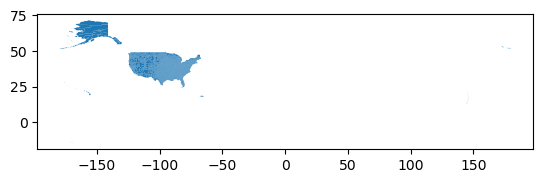

In [23]:
# d Plot counties
counties.plot()

Throughout my preliminary data exploratory, I was able to look at the top 5 rows that included the all the columns to get familiar with the data. I also looked at the data types that are in this dataset. After I was curious to see what CRS it is on, aswell as if it is projected or geographic. Lastly, I plotted the data to visually see it.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 6.B. Cleaning

Simplify column names as needed.

In [24]:
# Clean column names for counties shapefile
counties.columns = (
    counties.columns
    # Remove spaces
    .str.strip()
    # Lowercase all names
    .str.lower()  
    # Replace spaces with underscores
    .str.replace(' ', '_'))       


In [25]:
# Check counties geom type
counties.geom_type

0       Polygon
1       Polygon
2       Polygon
3       Polygon
4       Polygon
         ...   
3230    Polygon
3231    Polygon
3232    Polygon
3233    Polygon
3234    Polygon
Length: 3235, dtype: object

In [26]:
# View dataframe
counties.head(2)

,statefp,countyfp,countyns,geoid,geoidfq,name,namelsad,lsad,classfp,mtfcc,csafp,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,geometry
0,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477563029,10772508,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980771,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 6.C. Data selection

Select all the counties for the state of New York in a new variable `ny_counties` and plot them (you may need to look at the metadata).

In [27]:
# Select the states of New York, using statefp
ny_counties = counties[counties['statefp'] == '36']


Text(0.5, 1.0, 'Counties in New York')

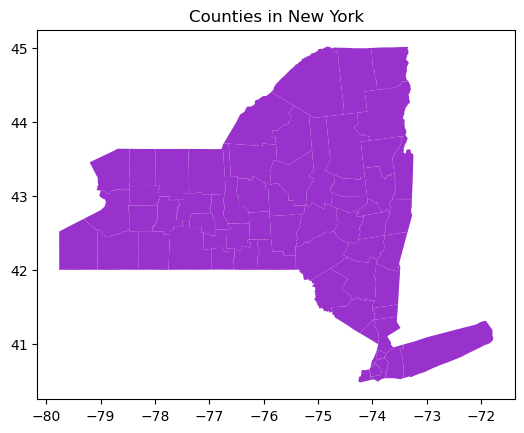

In [28]:
# Plot for only NY counties
ny_counties.plot(color = "darkorchid")
plt.title('Counties in New York') # Set Title

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## 7 Merging

The goal of this section is to create a single dataframe with the number of spills per county and the corresponding geometries for each county.

### 7.A. Explore data

In the next cells:

a. Print the names of counties in `ny_counties`, without repetition.


In [29]:
# Print names of ny_countries
ny_counties['name'].values

array(['Steuben', 'Saratoga', 'Allegany', 'Oswego', 'Ulster',
       'St. Lawrence', 'Schuyler', 'Essex', 'Suffolk', 'Hamilton',
       'Dutchess', 'Otsego', 'Tompkins', 'Albany', 'Cayuga', 'Greene',
       'Herkimer', 'Warren', 'Jefferson', 'Clinton', 'Nassau', 'Madison',
       'Washington', 'Westchester', 'Lewis', 'Ontario', 'Cortland',
       'Richmond', 'Erie', 'Putnam', 'Montgomery', 'Sullivan', 'Orleans',
       'Oneida', 'Cattaraugus', 'Yates', 'Tioga', 'Monroe', 'Schoharie',
       'Broome', 'Rensselaer', 'Seneca', 'Queens', 'Genesee', 'Wayne',
       'Niagara', 'Kings', 'Chemung', 'Wyoming', 'New York', 'Columbia',
       'Chautauqua', 'Franklin', 'Onondaga', 'Chenango', 'Fulton',
       'Rockland', 'Livingston', 'Delaware', 'Orange', 'Schenectady',
       'Bronx'], dtype=object)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

b. Print the names of counties in `spills_per_county`, without repetition. Examine the differences in the outputs.

In [30]:
# Print names of spills per county
spills_per_county['county'].values

array(['Albany', 'Allegany', 'Bronx', 'Broome', 'Cattaraugus', 'Cayuga',
       'Chautauqua', 'Chemung', 'Chenango', 'Clinton', 'Columbia',
       'Cortland', 'Delaware', 'Dutchess', 'Erie', 'Essex', 'Franklin',
       'Fulton', 'Genesee', 'Greene', 'Hamilton', 'Herkimer', 'Jefferson',
       'Kings', 'Lewis', 'Livingston', 'Madison', 'Monroe', 'Montgomery',
       'Nassau', 'New Jersey - Region 2', 'New York', 'Niagara', 'Oneida',
       'Onondaga', 'Ontario', 'Orange', 'Orleans', 'Oswego', 'Otsego',
       'Putnam', 'Queens', 'Rensselaer', 'Richmond', 'Rockland',
       'Saratoga', 'Schenectady', 'Schoharie', 'Schuyler', 'Seneca',
       'St Lawrence', 'Steuben', 'Suffolk', 'Sullivan', 'Tioga',
       'Tompkins', 'Tuscarora Indian Reservation', 'Ulster', 'Warren',
       'Washington', 'Wayne', 'Westchester', 'Wyoming', 'Yates'],
      dtype=object)

<!-- END QUESTION -->



c. Which are the county names that are in `spills_per_county`, but not in `ny_counties`? Your answer should be a list of strings
HINT: You can use the `numpy` function [`setdiff1d()`](https://numpy.org/doc/stable/reference/generated/numpy.setdiff1d.html), pay attention to the example in the documentation. Store your answer in the `diff_names` variable. 


In [31]:
# Compare the arrays of county names in spills but not the full dataframe
diff_names_spills = list(np.setdiff1d(
    spills_per_county['county'],
    ny_counties['name']
))

# Print new variable
diff_names_spills

['New Jersey - Region 2', 'St Lawrence', 'Tuscarora Indian Reservation']

In [32]:
# Checking length
print(len(diff_names_spills))

3


In [33]:
grader.check("7Ac")

7Ac results: All test cases passed!

d. Which are the county names that are in `ny_counties`, but not in `spills_per_county`? Your answer should be a list of strings.


In [34]:
# Counties in ny_counties but not in spills_per_county
diff_names_ny = list(np.setdiff1d(
    ny_counties['name'].unique(),        # all NY counties from TIGER
    spills_per_county['county'].unique() # counties with spills
))

# Check the result
print(diff_names_ny)
# Checking length
print(len(diff_names_ny))
# Printing new variable
diff_names_ny

['St. Lawrence']
1


['St. Lawrence']

In [35]:
grader.check("7Ad")

7Ad results: All test cases passed!

e. What is the number of spills in 'Tuscarora Indian Reservation'?


In [36]:
# e. Number of spills in Tuscarora Indian Reservation
spills_per_county[spills_per_county['county'] == 'Tuscarora Indian Reservation'] # none

,county,n_spills
56,Tuscarora Indian Reservation,1


### 7.B. Data updates

In the next cell, update 'St Lawrence' to 'St. Lawrence' in `spills_per_county` data frame and Verify the update was successful.


In [37]:
# Verify 'St Lawrence' on spills per county 
spills_per_county[spills_per_county['county'] == 'St Lawrence']
# Replace value
spills_per_county['county'] = spills_per_county['county'].replace({'St Lawrence':'St. Lawrence'})
#Verify change has been made
spills_per_county[spills_per_county['county'] == 'St. Lawrence']


,county,n_spills
50,St. Lawrence,65


### 7.C. Merge

In the following cells:

a. Use this cell to make any other updates needed for making an inner join of the `spills_per_county` and `ny_counties`. 


In [38]:
# Lowercase values in county column
spills_per_county['county'] = spills_per_county['county'].str.lower()
ny_counties['name'] = ny_counties['name'].str.lower()
# Renaming column on ny_counties to match spills per county
ny_counties = ny_counties.rename(columns={'name': 'county'})
# Verify column name change
ny_counties.head()


/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,statefp,countyfp,countyns,geoid,geoidfq,county,namelsad,lsad,classfp,mtfcc,csafp,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,geometry
46,36,101,00974148,36101,0500000US36101,steuben,Steuben County,06,H1,G4020,236,18500,None,A,3601398422,35039875,+42.2667252,-077.3855253,"POLYGON ((-77.08327 42.00002, -77.09391 41.999..."
165,36,091,00974143,36091,0500000US36091,saratoga,Saratoga County,06,H1,G4020,104,10580,None,A,2097812305,87488004,+43.1061353,-073.8553872,"POLYGON ((-73.67891 42.91221, -73.67938 42.911..."
173,36,003,00974100,36003,0500000US36003,allegany,Allegany County,06,H1,G4020,None,None,None,A,2666409356,12990521,+42.2478532,-078.0261531,"POLYGON ((-78.04342 42.51846, -78.04326 42.518..."
203,36,075,00974136,36075,0500000US36075,oswego,Oswego County,06,H1,G4020,532,45060,None,A,2464650884,933469962,+43.4614431,-076.2092618,"POLYGON ((-76.02509 43.70702, -76.02004 43.706..."
210,36,111,00974153,36111,0500000US36111,ulster,Ulster County,06,H1,G4020,408,28740,None,A,2911757764,94596810,+41.9472124,-074.2654582,"POLYGON ((-74.07480 42.09659, -74.06441 42.120..."


b. Over-write `ny_counties` as the  inner join of the `spills_per_county` and `ny_counties` dataframes.


In [39]:
# Perform the inner join and overwrite ny_counties
ny_counties = ny_counties.merge(
    spills_per_county[['county', 'n_spills']],
    on='county',
    how='inner'
)
# View new variable
ny_counties.head()

,statefp,countyfp,countyns,geoid,geoidfq,county,namelsad,lsad,classfp,mtfcc,csafp,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,geometry,n_spills
0,36,101,00974148,36101,0500000US36101,steuben,Steuben County,06,H1,G4020,236,18500,None,A,3601398422,35039875,+42.2667252,-077.3855253,"POLYGON ((-77.08327 42.00002, -77.09391 41.999...",72
1,36,091,00974143,36091,0500000US36091,saratoga,Saratoga County,06,H1,G4020,104,10580,None,A,2097812305,87488004,+43.1061353,-073.8553872,"POLYGON ((-73.67891 42.91221, -73.67938 42.911...",162
2,36,003,00974100,36003,0500000US36003,allegany,Allegany County,06,H1,G4020,None,None,None,A,2666409356,12990521,+42.2478532,-078.0261531,"POLYGON ((-78.04342 42.51846, -78.04326 42.518...",30
3,36,075,00974136,36075,0500000US36075,oswego,Oswego County,06,H1,G4020,532,45060,None,A,2464650884,933469962,+43.4614431,-076.2092618,"POLYGON ((-76.02509 43.70702, -76.02004 43.706...",68
4,36,111,00974153,36111,0500000US36111,ulster,Ulster County,06,H1,G4020,408,28740,None,A,2911757764,94596810,+41.9472124,-074.2654582,"POLYGON ((-74.07480 42.09659, -74.06441 42.120...",162



From our previous exploration we know that Tuscarora Indian Reservation will not be in the join. Tuscarora Indian Reservation is located within Niagara county. 

c. Since the Tuscarora Indian Reservation does not appear in the `ny_counties` dataframe, add one spill to Niagara county. We will add a note about this in our final map. Add the cells you need to make this update **and** verify that the dataframe was updated.

In [40]:
# Verifying Niagra is in the ny_counties dataframe
ny_counties[ny_counties['county'] == 'niagara']
# Increment Niagara
ny_counties.loc[ny_counties['county'] == 'Niagara', 'n_spills'] += 1
# Verify output
ny_counties[ny_counties['county'] == 'niagara']

,statefp,countyfp,countyns,geoid,geoidfq,county,namelsad,lsad,classfp,mtfcc,csafp,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,geometry,n_spills
45,36,063,00974130,36063,0500000US36063,niagara,Niagara County,06,H1,G4020,160,15380,None,A,1352876140,1598772310,+43.2726719,-078.8129431,"POLYGON ((-78.49165 43.08396, -78.49179 43.084...",88


## 8. Map
a. Create a choropleth map of the number of petroleum spills per county in the state of New York in 2023. 
Your map should be polished and have (at least) the following updates:
- a legend indicating the number of spills
- an updated color map
- a title 
- no axis
- an annotation with the data source (New York State Department of Environmental Conservation) and date of access



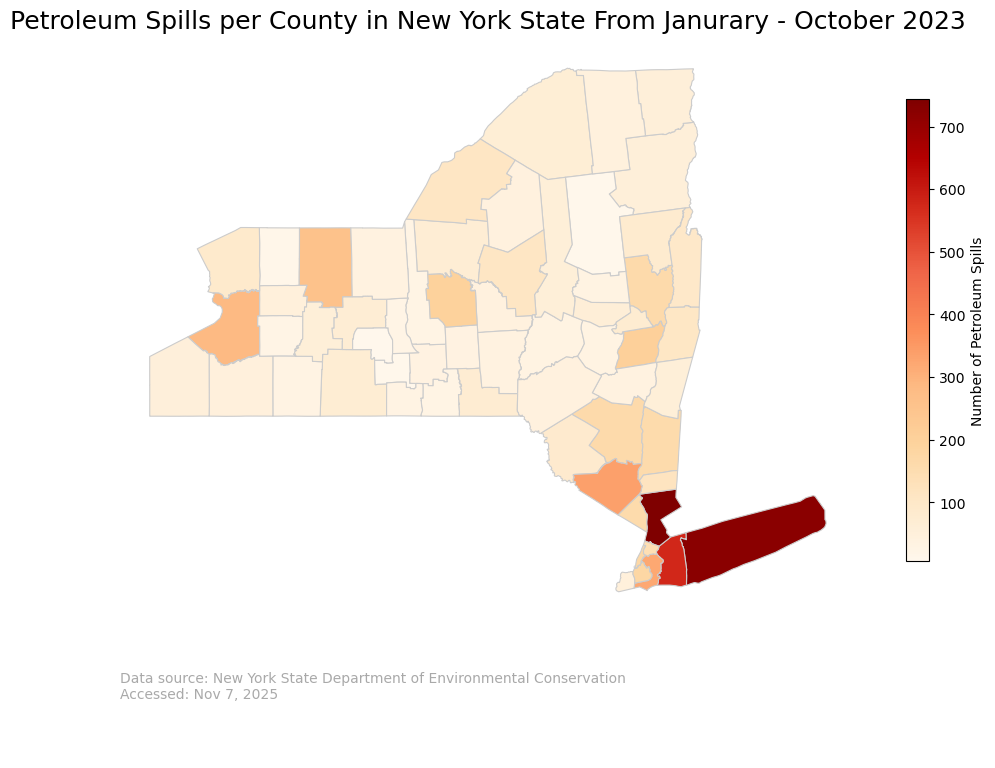

In [43]:
# Set up figure
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the choropleth
ny_counties.plot(
    # Column to color by
    column='n_spills', 
    # Color map (Orange-Red)
    cmap='OrRd',  
    # County boundaries width
    linewidth=0.8, 
    # County boundaries color (gray)
    edgecolor='0.8', 
    # Show legend
    legend=True,               
    legend_kwds={'label': "Number of Petroleum Spills",  # Title
                 # Size of scale bar
                 'shrink': 0.6,
                 # Location of scale
                 'orientation': 'vertical'},
    # Assinging it back to the fig, ax
    ax=ax)

# Axes
ax.axis('off')

# Title
ax.set_title("Petroleum Spills per County in New York State From Janurary - October 2023", fontdict={'fontsize': 18}, pad=10)

# Add annotation with source and access date
plt.annotate(
    "Data source: New York State Department of Environmental Conservation \nAccessed: Nov 7, 2025",
    # xy = location of annotation text
    xy=(0.1, 0.07), 
    xycoords='figure fraction',
    fontsize=10, color='darkgrey')

# Show plot
plt.show()

b. Write a description of how the map was created, including key takeaways. If you need to do additional data analysis to include relevant information from the data, you may include additional cells here.

The map was created by merging petroleum spill data from New York State with the 2023 TIGER/Line counties shapefile from the U.S. Census Bureau. Before merging, I converted date columns to datetime format and filtered the spills to those that occurred between January 1 and October 31, 2023. Column names were cleaned and standardized to ensure a proper join on county names. The datasets were merged using an inner join, linking county geometries with the number of petroleum spills. The resulting geospatial dataframe was visualized as a choropleth map using Matplotlib and GeoPandas, showing how spill frequency varies by county.

**Takeaways:** 
- Using function setdiff1d(), and merging two dataframes together 
- Spill counts were higher in urbanized and industrial regions.
- County name (“St Lawrence” switched to “St. Lawrence”) was corrected.
- The Tuscarora Indian Reservation spill was reassigned to Niagara County to maintain consistency with the shapefile boundaries.

## Complete workflow

**STILL WORKING ON THIS**

Collect all the relevant code into a **new notebook** titled `hwk3-task1-spills-COMPLETE-YOURLASTNAME.ipynb`. This notebook should have two sections:the a single cell will have the end-to-end workflow: from importing libraries and loading the data, to producing the graph. The *only* ouput of this cell should be the graph you produced in the previous exercise. Further guidance on what to include in this final workflow is in the assignment rubric.



**From last HW:**

Collect all the relevant code into the first blank cell of the notebook titled "COMPLETE WORKFLOW". This single cell will have the end-to-end workflow: from importing libraries and loading the data, to producing the graph. The only ouput of this cell should be the graph you produced in the previous exercise. Further guidance on what to include in this final workflow is in the assignment rubric.

##### Run the cell below to run all autograder tests. 

In [42]:
grader.check_all()

7Ac results: All test cases passed!

7Ad results: All test cases passed!

q5d results:
    q5d - 1 result:
        ❌ Test case failed
        Trying:
            def test_q3(student_data):
                try:
                    expected_data = pd.read_csv('data/q5d_df.csv').drop(columns='Unnamed: 0')
                    pd.testing.assert_frame_equal(expected_data, student_data)
                except AssertionError:
                    raise AssertionError('Incorrect answer.')
        Expecting nothing
        ok
        Trying:
            test_q3(spills_per_county)
        Expecting nothing
        **********************************************************************
        Line 7, in q5d 0
        Failed example:
            test_q3(spills_per_county)
        Exception raised:
            Traceback (most recent call last):
              File "<doctest q5d 0[0]>", line 4, in test_q3
                pd.testing.assert_frame_equal(expected_data, student_data)
              File "/op